In [2]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
from openai import OpenAI
import os
from dotenv import load_dotenv
import google.generativeai as genai

load_dotenv()

os.getenv('OPENAI_API_KEY')
genai.configure(api_key=os.getenv('GOOGLE_API_KEY'))

model = genai.GenerativeModel(model_name='gemini-1.5-flash-latest')
client = OpenAI()

In [4]:
PAIRWISE_JUDGE = """Please act as an impartial judge and evaluate the quality of the responses provided by two AI assistants to the user question displayed below. You should choose the assistant that follows the user's instructions and answers the user's question better. Your evaluation should consider factors such as the helpfulness, relevance, accuracy, depth, creativity, and level of detail of their responses. Begin your evaluation by comparing the two responses and provide a short explanation. Avoid any position biases and ensure that the order in which the responses were presented does not influence your decision. Do not allow the length of the responses to influence your evaluation. Do not favor certain names of the assistants. Be as objective as possible. After providing your explanation, output your final verdict by strictly following this format: \"[[A]]\" if assistant A is better, \"[[B]]\" if assistant B is better, and \"[[C]]\" for a tie."""

prompt_template = """[User Question]
{question}

[The Start of Assistant A's Answer]
{answer_a}
[The End of Assistant A's Answer]

[The Start of Assistant B's Answer]
{answer_b}
[The End of Assistant B's Answer]"""

description = "Prompt for general questions"
category = "{category}"
output_format = "[[A]]"

PAIRWISE_JUDGE_FULL = PAIRWISE_JUDGE + prompt_template + description + category + output_format

In [38]:
df = pd.read_csv('QuestionSet/Q3.csv')
# Drop the author column
df.drop('Author', axis=1, inplace=True)

# to lowercasing the columns
df['Category'] = df['Category'].str.lower()
df.head()

,Category,Question
0,combinatorics,Given a set X with n elements and a collection...
1,combinatorics,Show that it is possible to partition the vert...
2,combinatorics,Can you cover all the black squares in a chess...
3,combinatorics,"There are n boxes B1, B2, …, Bn in a row. N ba..."
4,combinatorics,"Let A1, A2, …, A6 be subsets of S = {1, 2, …, ..."


In [39]:
df.shape

(177, 2)

In [40]:
# Drop the rows with missing values in the Question column
df = df.dropna(subset=['Question'])

df['Question'].isnull().sum()

0

In [41]:
def get_answer_gpt(question):
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": question},
        ]
    )
    return response.choices[-1].message.content

In [42]:
def get_answer_gemini(question):
    response = model.generate_content(question)
    return response.text

In [43]:
df['GPT_Answer'] = [None] * len(df)
df['Gemini_Answer'] = [None] * len(df)

In [51]:
for i in range(len(df)):
    if df.iloc[i]['GPT_Answer'] is None:
        question = df.iloc[i]['Question']
        #set answer to the question
        df.at[i, 'GPT_Answer'] = get_answer_gpt(question)

In [53]:
# count mum of questions that have no answer
df['GPT_Answer'].isnull().sum()

1

In [65]:
# Remove the snake game from the question and remove the row
title = 'Program a snake game in python using pygame'

# Remove the specific title from the 'Question' column
df['Question'] = df['Question'].apply(lambda x: x.replace(title, '') if isinstance(x, str) else x)

# Remove rows where 'Question' is empty or NaN
df = df[df['Question'].notna() & (df['Question'] != '')]

In [66]:
#check if title is removed
df['Question'].str.contains(title).sum()

0

In [73]:
import time

# Apply the api rate limit
count = 0

for i in range(len(df)):
    if df.iloc[i]['Gemini_Answer'] is None:
        question = df.iloc[i]['Question']
        print(question)
        count += 1
        #set answer to the question
        df.at[i, 'Gemini_Answer'] = get_answer_gemini(question)
        if count == 15:
            # Sleep for 1 minute
            time.sleep(60)
            count = 0

A typical American-style crossword puzzle grid is an \(N \times N\) matrix with black and white squares, which obeys the following rules: every white square must be part of an "across" word and a "down" word; no word can be fewer than three letters long; every white square must be reachable from every other white square; the grid is rotationally symmetric (for example, the colors of the top left and bottom right squares must match). Write a program to determine whether a given matrix qualifies as a crossword grid.
Given a linked list, rearrange the node values such that they appear in alternating low -> high -> low -> high form. For example, given 1 -> 2 -> 3 -> 4 -> 5, you should return 1 -> 3 -> 2 -> 5 -> 4.


In [75]:
df['Gemini_Answer'].isnull().sum()

2

In [77]:
# Remove the rows with missing values in the their column
df = df.dropna(subset=['GPT_Answer', 'Gemini_Answer'])

In [78]:
df['GPT_Answer'].isnull().sum(), df['Gemini_Answer'].isnull().sum()

(0, 0)

In [79]:
df.to_csv('QuestionSet/Q3_Answers.csv', index=False)

In [80]:
df['Evaluation'] = [None] * len(df)

In [87]:
# Evaluator
for i in range(len(df)):
    if df.iloc[i]['Evaluation'] is None:
        question = df.iloc[i]['Question']

        category = df.iloc[i]['Category']
        
        answer_gpt = df.iloc[i]['GPT_Answer']
        answer_gemini = df.iloc[i]['Gemini_Answer']
        
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": PAIRWISE_JUDGE_FULL.format(question=question, category=category, answer_a=answer_gpt, answer_b=answer_gemini)},
            ]
        )  

        df.at[i, 'Evaluation'] = response.choices[-1].message.content


In [88]:
df.head()

,Category,Question,GPT_Answer,Gemini_Answer,Evaluation
0,combinatorics,Given a set X with n elements and a collection...,To prove that there exists a subset of \(X\) w...,This is a classic problem related to the **Erd...,Both Assistant A and Assistant B aimed to prov...
1,combinatorics,Show that it is possible to partition the vert...,To show that it is possible to partition the v...,This statement is not true for all graphs. Her...,In evaluating the responses from Assistant A a...
2,combinatorics,Can you cover all the black squares in a chess...,To check if we can cover all the black squares...,You can cover all the black squares of a chess...,**Evaluation of the Responses**\n\n1. **Helpfu...
3,combinatorics,"There are n boxes B1, B2, …, Bn in a row. N ba...",To prove that we can achieve a state where eac...,Here's a proof by induction that you can alway...,### Evaluation of Assistant Responses:\n\n1. *...
4,combinatorics,"Let A1, A2, …, A6 be subsets of S = {1, 2, …, ...","To determine \( m \), the number of times each...",Here's how to solve this problem:\n\n**Underst...,Both Assistant A and Assistant B provided clea...


In [93]:
# Save the evaluated data, we make sure that each row is in quotes for the csv file
df = df['Evaluation'].apply(lambda x: f'"{x}"')


df.to_csv('QuestionSet/Q3_evaluated.csv', index=False)
df.head()

AttributeError: 'str' object has no attribute 'apply'

In [7]:
new_df = pd.read_csv('QuestionSet/Samples_answer.csv')

In [8]:
new_df.head()

,Type:,Question:,GPT,Gemini:
0,math,Can you cover all the black squares in a chess...,To check if we can cover all the black squares...,You can cover all the black squares of a chess...
1,math,Six people are seated at a round table to play...,a) The seating arrangement around the table is...,Here's the breakdown:\n\na) **Circular Permuta...
2,coding,Implement a Python function to find the longes...,Finding the longest common subsequence (LCS) o...,```python\ndef longest_common_subsequence(str1...
3,combinatorics,Show that the number of ways to distribute n d...,To show that the number of ways to distribute ...,Here's how to show that the number of ways to ...
4,book,Lisa can row a boat at the rate of 3 km/h in s...,Let's break down the problem step by step.\n\n...,Here's how to solve this problem:\n\n**1. Down...


In [10]:
new_df['Evaluation'] = [None] * len(new_df)

# Evaluator
for i in range(len(new_df)):
    if new_df.iloc[i]['Evaluation'] is None:
        question = new_df.iloc[i]['Question:']

        category = new_df.iloc[i]['Type:']
        
        answer_gpt = new_df.iloc[i]['GPT']
        answer_gemini = new_df.iloc[i]['Gemini:']
        
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": PAIRWISE_JUDGE_FULL.format(question=question, category=category, answer_a=answer_gpt, answer_b=answer_gemini)},
            ]
        )  

        new_df.at[i, 'Evaluation'] = response.choices[-1].message.content


In [11]:
# Add a column for the final verdict
new_df['Final_Verdict'] = [None] * len(new_df)

for i in range(len(new_df)):
    if new_df.iloc[i]['Final_Verdict'] is None:
        evaluation = str(new_df.iloc[i]['Evaluation'])
        # Extract the final verdict from the evaluation
        if '[[A]]' in evaluation:
            new_df.at[i, 'Final_Verdict'] = 'A'
        elif '[[B]]' in evaluation:
            new_df.at[i, 'Final_Verdict'] = 'B'
        else:
            new_df.at[i, 'Final_Verdict'] = 'T'

new_df.head()

,Type:,Question:,GPT,Gemini:,Evaluation,Final_Verdict
0,math,Can you cover all the black squares in a chess...,To check if we can cover all the black squares...,You can cover all the black squares of a chess...,Both assistants provided well-thought-out resp...,B
1,math,Six people are seated at a round table to play...,a) The seating arrangement around the table is...,Here's the breakdown:\n\na) **Circular Permuta...,Both Assistant A and Assistant B provided corr...,A
2,coding,Implement a Python function to find the longes...,Finding the longest common subsequence (LCS) o...,```python\ndef longest_common_subsequence(str1...,Both Assistant A and Assistant B provided vali...,A
3,combinatorics,Show that the number of ways to distribute n d...,To show that the number of ways to distribute ...,Here's how to show that the number of ways to ...,Both responses from Assistant A and Assistant ...,B
4,book,Lisa can row a boat at the rate of 3 km/h in s...,Let's break down the problem step by step.\n\n...,Here's how to solve this problem:\n\n**1. Down...,Both Assistant A and Assistant B provided accu...,T


In [12]:
# Save the final verdict data
new_df.to_csv('QuestionSet/sample_verdict.csv', index=False)

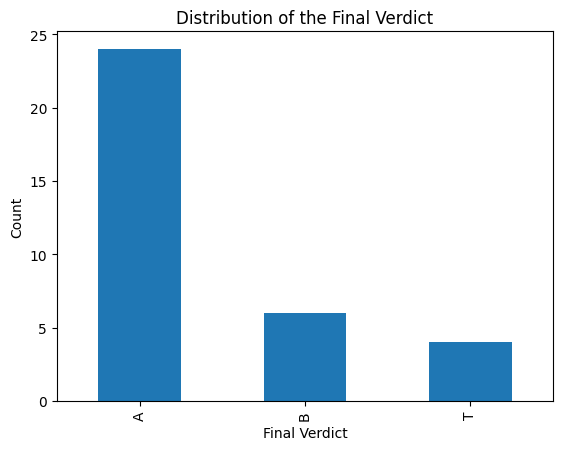

In [14]:
# Plot the distribution of the final verdict
import matplotlib.pyplot as plt

new_df['Final_Verdict'].value_counts().plot(kind='bar')
plt.xlabel('Final Verdict')
plt.ylabel('Count')
plt.title('Distribution of the Final Verdict')

plt.show()